# Product Funnel Optimization — SQL Validation (Python)
Purpose: Recompute core funnel metrics in Python to validate SQL logic before modeling.

In [4]:
import pandas as pd
import numpy as np

In [5]:
events = pd.read_csv("../data/events.csv", parse_dates=["event_timestamp"])
users = pd.read_csv("../data/users.csv", parse_dates=["signup_date"])
products = pd.read_csv("../data/products.csv")

In [6]:
events["event_type"].value_counts()

event_type
view        56013
cart        12035
wishlist     7946
purchase     4006
Name: count, dtype: int64

In [7]:
user_funnel_py = (
    events
    .assign(
        viewed=lambda x: (x["event_type"] == "view").astype(int),
        added_to_cart=lambda x: (x["event_type"] == "cart").astype(int),
        wishlisted=lambda x: (x["event_type"] == "wishlist").astype(int),
        purchased=lambda x: (x["event_type"] == "purchase").astype(int),
    )
    .groupby("user_id")[["viewed", "added_to_cart", "wishlisted", "purchased"]]
    .max()
    .reset_index()
)

In [8]:
user_funnel_py[["viewed", "added_to_cart", "wishlisted", "purchased"]].sum()

viewed           9961
added_to_cart    6994
wishlisted       5504
purchased        3281
dtype: int64

In [9]:
# Aggregate user behavior
user_features = (
    events
    .groupby("user_id")
    .agg(
        num_views=("event_type", lambda x: (x == "view").sum()),
        num_cart_adds=("event_type", lambda x: (x == "cart").sum()),
        num_wishlists=("event_type", lambda x: (x == "wishlist").sum()),
        num_purchases=("event_type", lambda x: (x == "purchase").sum()),
    )
    .reset_index()
)

# Target: did the user ever purchase?
user_features["converted"] = (user_features["num_purchases"] > 0).astype(int)

In [10]:
# Merge signup info
user_features = user_features.merge(
    users[["user_id", "signup_date"]],
    on="user_id",
    how="left"
)

# User tenure in days
max_event_date = events["event_timestamp"].max()
user_features["tenure_days"] = (
    max_event_date - user_features["signup_date"]
).dt.days

In [11]:
X = user_features[
    ["num_views", "num_cart_adds", "num_wishlists", "tenure_days"]
]
y = user_features["converted"]

In [12]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X, y)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [13]:
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coefficient": model.coef_[0]
}).sort_values("coefficient", ascending=False)

coef_df

,feature,coefficient
0,num_views,0.015594
2,num_wishlists,0.015389
3,tenure_days,-0.000084
1,num_cart_adds,-0.001878


In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model_std = LogisticRegression(max_iter=1000)
model_std.fit(X_scaled, y)

pd.DataFrame({
    "feature": X.columns,
    "coefficient": model_std.coef_[0]
}).sort_values("coefficient", ascending=False)

,feature,coefficient
0,num_views,0.036680
2,num_wishlists,0.013647
1,num_cart_adds,-0.002100
3,tenure_days,-0.016584


In [15]:
user_features["conversion_probability"] = model_std.predict_proba(X_scaled)[:, 1]

In [16]:
user_features[["user_id", "conversion_probability"]].head()

,user_id,conversion_probability
0,U000001,0.321910
1,U000002,0.321835
2,U000003,0.344820
3,U000004,0.311789
4,U000005,0.324952


# Product Funnel Optimization — Visual Analysis
Purpose: Visualize funnel performance, drop-offs, trends, and model insights to support business decisions.

In [17]:
funnel_counts = pd.DataFrame({
    "stage": ["View", "Cart", "Wishlist", "Purchase"],
    "users": [
        user_funnel_py["viewed"].sum(),
        user_funnel_py["added_to_cart"].sum(),
        user_funnel_py["wishlisted"].sum(),
        user_funnel_py["purchased"].sum()
    ]
})

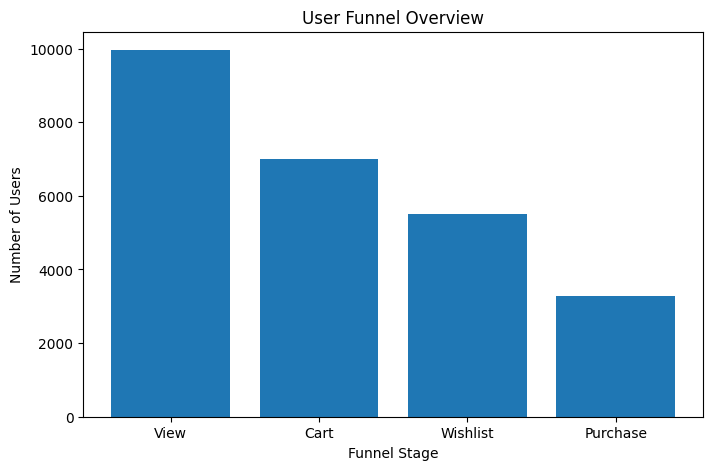

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(funnel_counts["stage"], funnel_counts["users"])
plt.title("User Funnel Overview")
plt.ylabel("Number of Users")
plt.xlabel("Funnel Stage")
plt.show()

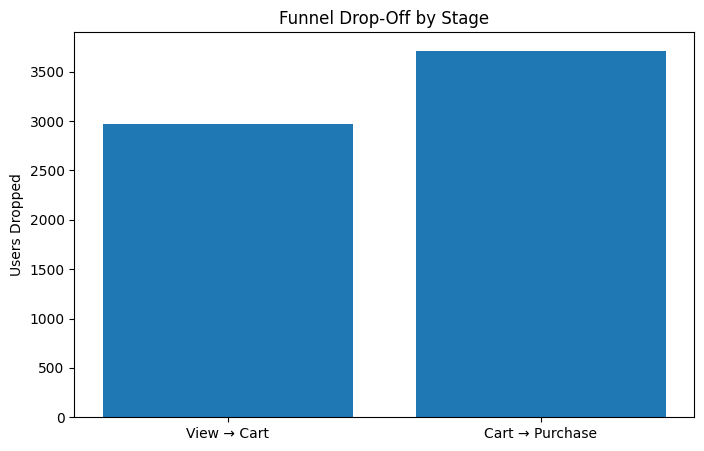

In [19]:
dropoff = pd.DataFrame({
    "stage": ["View → Cart", "Cart → Purchase"],
    "users_dropped": [
        funnel_counts.loc[0, "users"] - funnel_counts.loc[1, "users"],
        funnel_counts.loc[1, "users"] - funnel_counts.loc[3, "users"]
    ]
})

plt.figure(figsize=(8,5))
plt.bar(dropoff["stage"], dropoff["users_dropped"])
plt.title("Funnel Drop-Off by Stage")
plt.ylabel("Users Dropped")
plt.show()

In [20]:
weekly = (
    events
    .assign(week=lambda x: x["event_timestamp"].dt.to_period("W").dt.start_time)
    .groupby("week")
    .agg(
        viewers=("event_type", lambda x: (x=="view").sum()),
        buyers=("event_type", lambda x: (x=="purchase").sum())
    )
    .reset_index()
)

weekly["conversion_rate"] = weekly["buyers"] / weekly["viewers"] * 100

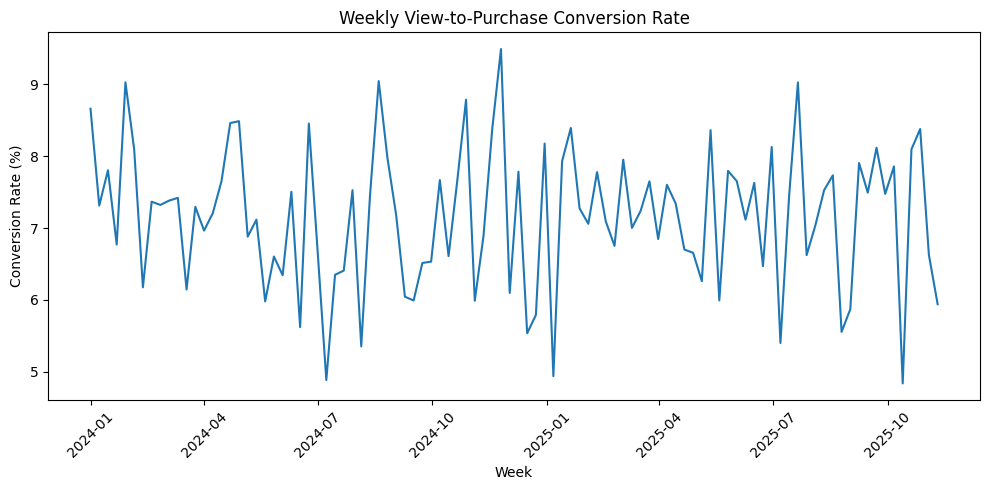

In [21]:
plt.figure(figsize=(10,5))
plt.plot(weekly["week"], weekly["conversion_rate"])
plt.title("Weekly View-to-Purchase Conversion Rate")
plt.ylabel("Conversion Rate (%)")
plt.xlabel("Week")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [22]:
category_conv = (
    events
    .merge(products, on="product_id")
    .groupby("category")
    .agg(
        viewers=("event_type", lambda x: (x=="view").sum()),
        buyers=("event_type", lambda x: (x=="purchase").sum())
    )
    .reset_index()
)

category_conv["conversion_rate"] = (
    category_conv["buyers"] / category_conv["viewers"] * 100
)

category_conv = category_conv.sort_values("conversion_rate", ascending=False)

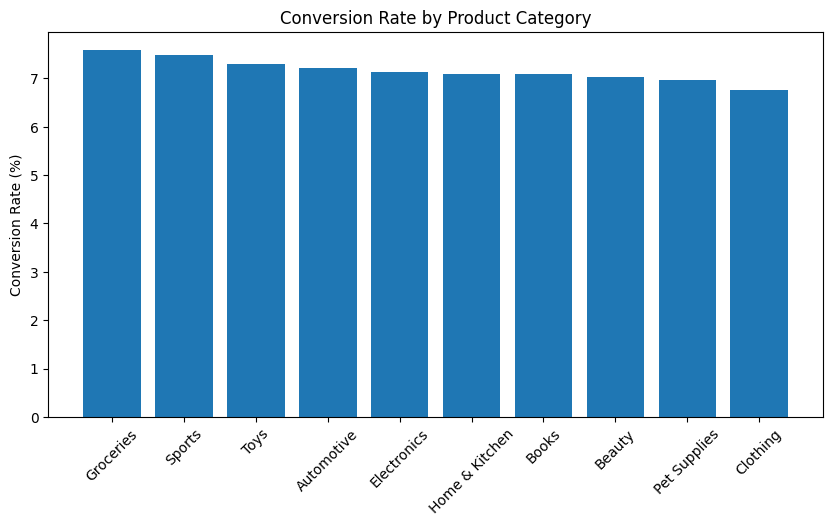

In [23]:
plt.figure(figsize=(10,5))
plt.bar(category_conv["category"], category_conv["conversion_rate"])
plt.title("Conversion Rate by Product Category")
plt.ylabel("Conversion Rate (%)")
plt.xticks(rotation=45)
plt.show()

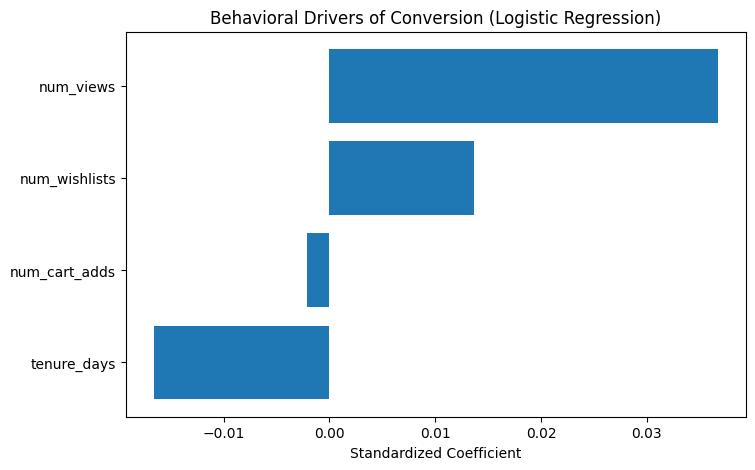

In [24]:
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coefficient": model_std.coef_[0]
}).sort_values("coefficient")

plt.figure(figsize=(8,5))
plt.barh(coef_df["feature"], coef_df["coefficient"])
plt.title("Behavioral Drivers of Conversion (Logistic Regression)")
plt.xlabel("Standardized Coefficient")
plt.show()